In [21]:
!export OMP_NUM_THREADS=4

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from pathlib import Path

## single model

In [23]:
model = 3
workdir = Path(f'work/chaos/lorenz{model}')
if not workdir.exists():
    workdir.mkdir(parents=True)

### model


In [24]:
from model.lorenz import L96
from model.lorenz2 import L05II
from model.lorenz3 import L05III

if model == 1:
    # Lorenz I
    nx = 40
    F = 8.0
    h = 0.05
    step = L96(nx,h,F)
elif model == 2:
    # Lorenz II
    nx = 240
    nk = 8
    h = 0.05
    F = 10.0
    step = L05II(nx,nk,h,F)
elif model==3:
    # Lorenz III
    nx = 960
    nk = 32
    ni = 12
    b = 10.0
    c = 0.6
    h = 0.05 / b
    F = 15.0
    step = L05III(nx,nk,ni,b,c,h,F)

ni=12 alpha=0.124 beta=0.014
nx=960 nk=32
F=15.0 dt=5.000e-03
b=10.0 c=0.6


In [28]:
phi = np.linspace(0.0,2.0*np.pi,nx+1)
x = np.cos(phi)
y = np.sin(phi)

### observation operator

In [25]:
from analysis.obs import Obs
obs = Obs('linear',1.0)

2024-02-07 18:28:56,992 anl INFO operator=linear, obserr=1.0
2024-02-07 18:28:56,993 anl INFO nvars=1


### analysis method

In [50]:
from analysis.envar import EnVAR
ne = 30
analysis = EnVAR(nx,ne,obs,linf=True,infl_parm=1.01)

2024-02-07 18:50:38,879 anl INFO model : model
2024-02-07 18:50:38,880 anl INFO ndim=960 nmem=30
2024-02-07 18:50:38,880 anl INFO pt=envar op=linear sig=1.0 infl_parm=1.01 lsig=-1.0
2024-02-07 18:50:38,880 anl INFO linf=True iloc=None ltlm=False incremental=True


### truth and initial ensemble

In [51]:
z0i = np.zeros(nx)
z0i[nx//2] += F*0.01
for i in range(100*int(0.05/h)):
    z0i = step(z0i)
ne = 30
z0ei = np.zeros((nx,ne))
for j in range(ne):
    z0ei[:,j] = z0i[:]
    z0ei[:,j] = z0i[:] + np.random.randn(nx)*0.1

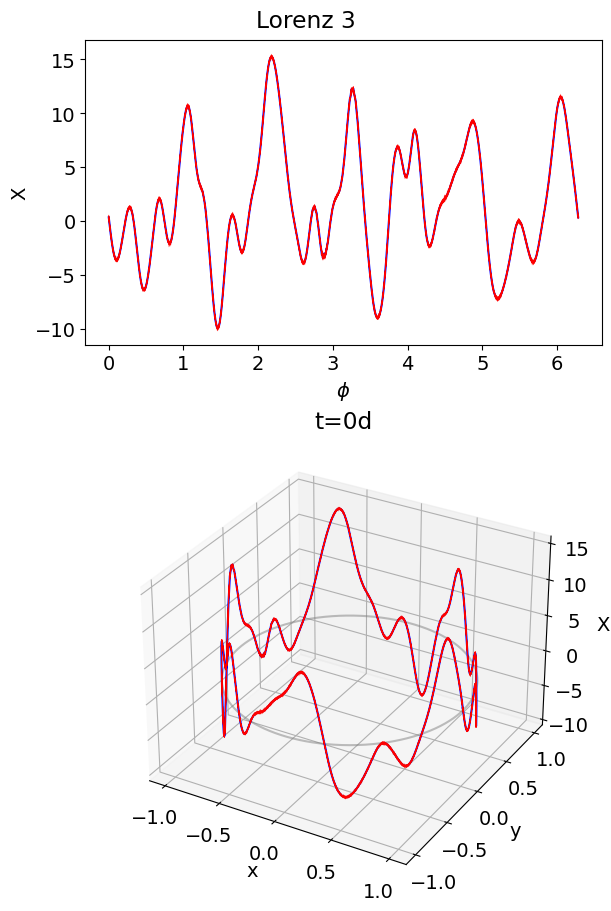

In [52]:
zb = np.hstack((z0i,[z0i[0]]))
zbe = np.vstack((z0ei,z0ei[0].reshape(1,-1)))
t=0.0
fig = plt.figure(figsize=[6,9],constrained_layout=True)
gs0 = gridspec.GridSpec(5,1,figure=fig)
ax0 = fig.add_subplot(gs0[:2,:])
ax1 = fig.add_subplot(gs0[2:,:],projection='3d')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel('X')
ax1.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_zlabel('X')
labels = []
lines = []
ax0.plot(phi,zb,c='b',lw=1.5)
ax1.plot(x,y,zb,c='b',lw=1.5)
labels.append('truth')
lines.append(Line2D([0],[0],color='b',lw=1.5))
for i in range(zbe.shape[1]):
    #c = cmap(i)
    c = 'r'
    ax0.plot(phi,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x,y,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('ensemble forecast')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax1.set_title(f't={int(t/0.05/4)}d')
fig.suptitle(f'Lorenz {model}')
fig.savefig(workdir/'chaos_initial.png',dpi=300)
plt.show()

### settings

In [53]:
nt6h = int(0.05/h)
nt24h = nt6h * 4
ntmax = nt24h * 40
nstanl = nt24h * 20 # assimilation start
zt = []
ze = []
za = []
cycles = []
z0 = z0i.copy()
z0e = z0ei.copy()
z0a = z0e.copy()
zt.append(z0)
ze.append(z0e)
za.append(z0a)

In [54]:
icycle = 0
for i in range(ntmax):
    t += h
    z0 = step(z0)
    z0e = step(z0e)
    z0a = step(z0a)
    if i % nt6h == 0:
        if i >= nstanl and i % nt24h == 0:
            icycle += 1
            print(f"{icycle}cycle")
            cycles.append(icycle)
            obsloc = np.arange(0,nx,6)
            yobs = obs.add_noise(obs.h_operator(obsloc,z0))
            z0a,_,_,_,_,_ = analysis(z0a,z0a,yobs,obsloc)
        zt.append(z0)
        ze.append(z0e)
        za.append(z0a)
print(f"total: {icycle}cycle")

2024-02-07 18:51:36,363 anl INFO save_dh=False
2024-02-07 18:51:36,368 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:36,398 anl INFO method=CG
2024-02-07 18:51:36,405 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:36,408 anl INFO restart=False
2024-02-07 18:51:36,410 anl INFO save_hist=False
2024-02-07 18:51:36,411 anl INFO jb:0.000000e+00 jo:1.826506e+03
2024-02-07 18:51:36,413 anl INFO |dj|:5.639938e+01
2024-02-07 18:51:36,415 anl INFO jb:6.249033e-03 jo:1.770047e+03
2024-02-07 18:51:36,419 anl INFO |dj|:5.538925e+01
2024-02-07 18:51:36,421 anl INFO jb:1.562258e-01 jo:1.554286e+03
2024-02-07 18:51:36,423 anl INFO |dj|:5.134876e+01
2024-02-07 18:51:36,425 anl INFO jb:2.755823e+00 jo:8.524788e+02
2024-02-07 18:51:36,427 anl INFO |dj|:3.518680e+01
2024-02-07 18:51:36,428 anl INFO jb:1.948109e+01 jo:2.167731e+02
2024-02-07 18:51:36,431 anl INFO |dj|:1.776228e-02
2024-02-07 18:51:36,435 anl INFO jb:1.944927e+01 jo:2.168048e+02
2024-02-07 18:51:36,437 anl INFO |dj|:5.443115e-05
20

1cycle


2024-02-07 18:51:38,400 anl INFO save_dh=False
2024-02-07 18:51:38,403 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:38,427 anl INFO method=CG
2024-02-07 18:51:38,428 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:38,429 anl INFO restart=False
2024-02-07 18:51:38,432 anl INFO save_hist=False
2024-02-07 18:51:38,434 anl INFO jb:0.000000e+00 jo:2.631177e+02
2024-02-07 18:51:38,435 anl INFO |dj|:1.030650e+01
2024-02-07 18:51:38,437 anl INFO jb:2.158821e-01 jo:2.530044e+02
2024-02-07 18:51:38,438 anl INFO |dj|:9.292271e+00
2024-02-07 18:51:38,440 anl INFO jb:5.397053e+00 jo:2.184775e+02
2024-02-07 18:51:38,449 anl INFO |dj|:5.235354e+00
2024-02-07 18:51:38,454 anl INFO jb:2.229278e+01 jo:1.879346e+02
2024-02-07 18:51:38,456 anl INFO |dj|:2.449512e-02
2024-02-07 18:51:38,458 anl INFO jb:2.223256e+01 jo:1.879945e+02
2024-02-07 18:51:38,462 anl INFO |dj|:1.158506e-04
2024-02-07 18:51:38,465 anl INFO jb:2.223256e+01 jo:1.879945e+02
2024-02-07 18:51:38,468 anl INFO |dj|:1.012104e-04
20

2cycle


2024-02-07 18:51:40,616 anl INFO save_dh=False
2024-02-07 18:51:40,620 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:40,639 anl INFO method=CG
2024-02-07 18:51:40,640 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:40,643 anl INFO restart=False
2024-02-07 18:51:40,643 anl INFO save_hist=False
2024-02-07 18:51:40,647 anl INFO jb:0.000000e+00 jo:2.027291e+02
2024-02-07 18:51:40,650 anl INFO |dj|:1.018547e+01
2024-02-07 18:51:40,651 anl INFO jb:1.958939e-01 jo:1.927579e+02
2024-02-07 18:51:40,661 anl INFO |dj|:9.171625e+00
2024-02-07 18:51:40,663 anl INFO jb:4.897346e+00 jo:1.591949e+02
2024-02-07 18:51:40,668 anl INFO |dj|:5.116272e+00
2024-02-07 18:51:40,669 anl INFO jb:1.977166e+01 jo:1.312821e+02
2024-02-07 18:51:40,671 anl INFO |dj|:1.982615e-02
2024-02-07 18:51:40,672 anl INFO jb:1.973223e+01 jo:1.313214e+02
2024-02-07 18:51:40,675 anl INFO |dj|:1.228902e-04
2024-02-07 18:51:40,681 anl INFO jb:1.973222e+01 jo:1.313214e+02
2024-02-07 18:51:40,682 anl INFO |dj|:1.158826e-04
20

3cycle


2024-02-07 18:51:42,773 anl INFO save_dh=False
2024-02-07 18:51:42,776 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:42,797 anl INFO method=CG
2024-02-07 18:51:42,800 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:42,801 anl INFO restart=False
2024-02-07 18:51:42,803 anl INFO save_hist=False
2024-02-07 18:51:42,805 anl INFO jb:0.000000e+00 jo:2.194019e+02
2024-02-07 18:51:42,806 anl INFO |dj|:1.345703e+01
2024-02-07 18:51:42,809 anl INFO jb:9.231400e-02 jo:2.062290e+02
2024-02-07 18:51:42,811 anl INFO |dj|:1.244522e+01
2024-02-07 18:51:42,813 anl INFO jb:2.307850e+00 jo:1.619102e+02
2024-02-07 18:51:42,814 anl INFO |dj|:8.397988e+00
2024-02-07 18:51:42,816 anl INFO jb:1.632933e+01 jo:1.126887e+02
2024-02-07 18:51:42,822 anl INFO |dj|:2.327913e-02
2024-02-07 18:51:42,824 anl INFO jb:1.627486e+01 jo:1.127429e+02
2024-02-07 18:51:42,827 anl INFO |dj|:1.535537e-04
2024-02-07 18:51:42,830 anl INFO jb:1.627486e+01 jo:1.127429e+02
2024-02-07 18:51:42,832 anl INFO |dj|:1.402326e-04
20

4cycle


2024-02-07 18:51:44,672 anl INFO save_dh=False
2024-02-07 18:51:44,674 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:44,685 anl INFO method=CG
2024-02-07 18:51:44,688 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:44,689 anl INFO restart=False
2024-02-07 18:51:44,691 anl INFO save_hist=False
2024-02-07 18:51:44,693 anl INFO jb:0.000000e+00 jo:1.161707e+02
2024-02-07 18:51:44,703 anl INFO |dj|:5.008213e+00
2024-02-07 18:51:44,718 anl INFO jb:2.532470e-01 jo:1.113718e+02
2024-02-07 18:51:44,727 anl INFO |dj|:3.993249e+00
2024-02-07 18:51:44,732 anl INFO jb:6.166059e+00 jo:9.752494e+01
2024-02-07 18:51:44,734 anl INFO |dj|:1.375728e-02
2024-02-07 18:51:44,736 anl INFO jb:6.147086e+00 jo:9.754382e+01
2024-02-07 18:51:44,737 anl INFO |dj|:7.535973e-05
2024-02-07 18:51:44,740 anl INFO jb:6.147086e+00 jo:9.754382e+01
2024-02-07 18:51:44,743 anl INFO |dj|:7.078576e-05
2024-02-07 18:51:44,744 anl INFO jb:6.147098e+00 jo:9.754381e+01
2024-02-07 18:51:44,749 anl INFO |dj|:6.136770e-05
20

5cycle


2024-02-07 18:51:46,739 anl INFO save_dh=False
2024-02-07 18:51:46,740 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:46,758 anl INFO method=CG
2024-02-07 18:51:46,766 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:46,782 anl INFO restart=False
2024-02-07 18:51:46,799 anl INFO save_hist=False
2024-02-07 18:51:46,801 anl INFO jb:0.000000e+00 jo:1.510729e+02
2024-02-07 18:51:46,803 anl INFO |dj|:8.082547e+00
2024-02-07 18:51:46,806 anl INFO jb:1.924026e-01 jo:1.432291e+02
2024-02-07 18:51:46,817 anl INFO |dj|:7.068775e+00
2024-02-07 18:51:46,822 anl INFO jb:4.810064e+00 jo:1.182449e+02
2024-02-07 18:51:46,832 anl INFO |dj|:3.013705e+00
2024-02-07 18:51:46,835 anl INFO jb:1.224563e+01 jo:1.062850e+02
2024-02-07 18:51:46,837 anl INFO |dj|:1.288966e-02
2024-02-07 18:51:46,839 anl INFO jb:1.223480e+01 jo:1.062958e+02
2024-02-07 18:51:46,853 anl INFO |dj|:1.125249e-02
2024-02-07 18:51:46,861 anl INFO jb:1.222420e+01 jo:1.063063e+02
2024-02-07 18:51:46,863 anl INFO |dj|:7.741921e-03
20

6cycle


2024-02-07 18:51:46,976 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:47,015 anl INFO converge gmat, iter_num=3, norm=1.552406328789959e-06
2024-02-07 18:51:47,044 anl INFO err=0.009493661916040876
2024-02-07 18:51:49,543 anl INFO save_dh=False
2024-02-07 18:51:49,561 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:49,574 anl INFO method=CG
2024-02-07 18:51:49,582 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:49,583 anl INFO restart=False
2024-02-07 18:51:49,588 anl INFO save_hist=False
2024-02-07 18:51:49,611 anl INFO jb:0.000000e+00 jo:1.056869e+02
2024-02-07 18:51:49,621 anl INFO |dj|:4.771855e+00
2024-02-07 18:51:49,629 anl INFO jb:2.571349e-01 jo:1.011228e+02
2024-02-07 18:51:49,630 anl INFO |dj|:3.756814e+00
2024-02-07 18:51:49,631 anl INFO jb:5.682873e+00 jo:8.867527e+01
2024-02-07 18:51:49,633 anl INFO |dj|:9.259517e-03
2024-02-07 18:51:49,634 anl INFO jb:5.674286e+00 jo:8.868382e+01
2024-02-07 18:51:49,637 anl INFO |dj|:6.425985e-05
2024-02-07 18:51:49,644 anl IN

7cycle


2024-02-07 18:51:49,717 anl INFO converge gmat, iter_num=3, norm=1.680643837621895e-06
2024-02-07 18:51:49,733 anl INFO err=0.0028826722463869666
2024-02-07 18:51:52,564 anl INFO save_dh=False
2024-02-07 18:51:52,568 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:52,582 anl INFO method=CG
2024-02-07 18:51:52,583 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:52,583 anl INFO restart=False
2024-02-07 18:51:52,586 anl INFO save_hist=False
2024-02-07 18:51:52,588 anl INFO jb:0.000000e+00 jo:1.207163e+02
2024-02-07 18:51:52,590 anl INFO |dj|:5.947864e+00
2024-02-07 18:51:52,591 anl INFO jb:2.297468e-01 jo:1.149916e+02
2024-02-07 18:51:52,594 anl INFO |dj|:4.933360e+00
2024-02-07 18:51:52,596 anl INFO jb:5.743671e+00 jo:9.774407e+01
2024-02-07 18:51:52,598 anl INFO |dj|:8.754109e-01
2024-02-07 18:51:52,601 anl INFO jb:7.893122e+00 jo:9.521314e+01
2024-02-07 18:51:52,603 anl INFO |dj|:4.294381e-03
2024-02-07 18:51:52,605 anl INFO jb:7.890668e+00 jo:9.521559e+01
2024-02-07 18:51:52,609

8cycle


2024-02-07 18:51:54,903 anl INFO save_dh=False
2024-02-07 18:51:54,913 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:54,933 anl INFO method=CG
2024-02-07 18:51:54,934 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:54,935 anl INFO restart=False
2024-02-07 18:51:54,938 anl INFO save_hist=False
2024-02-07 18:51:54,941 anl INFO jb:0.000000e+00 jo:1.068674e+02
2024-02-07 18:51:54,943 anl INFO |dj|:4.500528e+00
2024-02-07 18:51:54,946 anl INFO jb:2.642123e-01 jo:1.025703e+02
2024-02-07 18:51:54,948 anl INFO |dj|:3.485349e+00
2024-02-07 18:51:54,951 anl INFO jb:5.192706e+00 jo:9.159895e+01
2024-02-07 18:51:54,952 anl INFO |dj|:1.220303e-02
2024-02-07 18:51:54,954 anl INFO jb:5.177789e+00 jo:9.161380e+01
2024-02-07 18:51:54,958 anl INFO |dj|:7.885608e-05
2024-02-07 18:51:54,962 anl INFO jb:5.177789e+00 jo:9.161380e+01
2024-02-07 18:51:54,963 anl INFO |dj|:7.584879e-05
2024-02-07 18:51:54,966 anl INFO jb:5.177796e+00 jo:9.161379e+01
2024-02-07 18:51:54,967 anl INFO |dj|:6.973625e-05
20

9cycle


2024-02-07 18:51:57,614 anl INFO save_dh=False
2024-02-07 18:51:57,618 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:51:57,650 anl INFO method=CG
2024-02-07 18:51:57,651 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:51:57,655 anl INFO restart=False
2024-02-07 18:51:57,659 anl INFO save_hist=False
2024-02-07 18:51:57,663 anl INFO jb:0.000000e+00 jo:1.764969e+02
2024-02-07 18:51:57,666 anl INFO |dj|:7.033876e+00
2024-02-07 18:51:57,670 anl INFO jb:2.429134e-01 jo:1.696622e+02
2024-02-07 18:51:57,671 anl INFO |dj|:6.019114e+00
2024-02-07 18:51:57,674 anl INFO jb:6.072836e+00 jo:1.477144e+02
2024-02-07 18:51:57,675 anl INFO |dj|:1.960114e+00
2024-02-07 18:51:57,677 anl INFO jb:1.167395e+01 jo:1.402012e+02
2024-02-07 18:51:57,679 anl INFO |dj|:1.067295e-02
2024-02-07 18:51:57,684 anl INFO jb:1.166324e+01 jo:1.402119e+02
2024-02-07 18:51:57,686 anl INFO |dj|:9.207077e-03
2024-02-07 18:51:57,690 anl INFO jb:1.165278e+01 jo:1.402223e+02
2024-02-07 18:51:57,692 anl INFO |dj|:6.042023e-03
20

10cycle


2024-02-07 18:52:00,488 anl INFO save_dh=False
2024-02-07 18:52:00,490 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:00,504 anl INFO method=CG
2024-02-07 18:52:00,515 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:00,529 anl INFO restart=False
2024-02-07 18:52:00,534 anl INFO save_hist=False
2024-02-07 18:52:00,537 anl INFO jb:0.000000e+00 jo:1.260269e+02
2024-02-07 18:52:00,540 anl INFO |dj|:5.611536e+00
2024-02-07 18:52:00,543 anl INFO jb:2.301503e-01 jo:1.206414e+02
2024-02-07 18:52:00,547 anl INFO |dj|:4.597024e+00
2024-02-07 18:52:00,549 anl INFO jb:5.753758e+00 jo:1.047431e+02
2024-02-07 18:52:00,551 anl INFO |dj|:5.390624e-01
2024-02-07 18:52:00,553 anl INFO jb:7.036848e+00 jo:1.033153e+02
2024-02-07 18:52:00,554 anl INFO |dj|:2.580332e-03
2024-02-07 18:52:00,557 anl INFO jb:7.035729e+00 jo:1.033165e+02
2024-02-07 18:52:00,560 anl INFO |dj|:2.381521e-03
2024-02-07 18:52:00,561 anl INFO jb:7.034701e+00 jo:1.033175e+02
2024-02-07 18:52:00,563 anl INFO |dj|:1.968099e-03
20

11cycle


2024-02-07 18:52:02,829 anl INFO save_dh=False
2024-02-07 18:52:02,834 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:02,851 anl INFO method=CG
2024-02-07 18:52:02,852 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:02,853 anl INFO restart=False
2024-02-07 18:52:02,858 anl INFO save_hist=False
2024-02-07 18:52:02,868 anl INFO jb:0.000000e+00 jo:1.468399e+02
2024-02-07 18:52:02,869 anl INFO |dj|:7.018664e+00
2024-02-07 18:52:02,872 anl INFO jb:2.575428e-01 jo:1.400061e+02
2024-02-07 18:52:02,876 anl INFO |dj|:6.003615e+00
2024-02-07 18:52:02,880 anl INFO jb:6.438569e+00 jo:1.177721e+02
2024-02-07 18:52:02,885 anl INFO |dj|:1.943441e+00
2024-02-07 18:52:02,887 anl INFO jb:1.233479e+01 jo:1.099968e+02
2024-02-07 18:52:02,889 anl INFO |dj|:1.035773e-02
2024-02-07 18:52:02,893 anl INFO jb:1.232999e+01 jo:1.100016e+02
2024-02-07 18:52:02,895 anl INFO |dj|:9.727965e-03
2024-02-07 18:52:02,897 anl INFO jb:1.232545e+01 jo:1.100061e+02
2024-02-07 18:52:02,901 anl INFO |dj|:8.430541e-03
20

12cycle


2024-02-07 18:52:03,039 anl INFO err=0.0024063217897992363
2024-02-07 18:52:05,287 anl INFO save_dh=False
2024-02-07 18:52:05,291 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:05,309 anl INFO method=CG
2024-02-07 18:52:05,310 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:05,313 anl INFO restart=False
2024-02-07 18:52:05,316 anl INFO save_hist=False
2024-02-07 18:52:05,319 anl INFO jb:0.000000e+00 jo:1.317944e+02
2024-02-07 18:52:05,322 anl INFO |dj|:5.750431e+00
2024-02-07 18:52:05,325 anl INFO jb:2.974306e-01 jo:1.262020e+02
2024-02-07 18:52:05,327 anl INFO |dj|:4.734600e+00
2024-02-07 18:52:05,328 anl INFO jb:7.435765e+00 jo:1.081438e+02
2024-02-07 18:52:05,331 anl INFO |dj|:6.713324e-01
2024-02-07 18:52:05,332 anl INFO jb:9.535033e+00 jo:1.058205e+02
2024-02-07 18:52:05,335 anl INFO |dj|:4.019937e-03
2024-02-07 18:52:05,338 anl INFO jb:9.533881e+00 jo:1.058216e+02
2024-02-07 18:52:05,341 anl INFO |dj|:3.867286e-03
2024-02-07 18:52:05,343 anl INFO jb:9.532857e+00 jo:1.05822

13cycle


2024-02-07 18:52:05,455 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:05,599 anl INFO converge gmat, iter_num=3, norm=1.1308513088470025e-06
2024-02-07 18:52:05,600 anl INFO err=0.004930867110919943
2024-02-07 18:52:07,879 anl INFO save_dh=False
2024-02-07 18:52:07,882 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:07,888 anl INFO method=CG
2024-02-07 18:52:07,899 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:07,910 anl INFO restart=False
2024-02-07 18:52:07,916 anl INFO save_hist=False
2024-02-07 18:52:07,919 anl INFO jb:0.000000e+00 jo:1.234170e+02
2024-02-07 18:52:07,923 anl INFO |dj|:4.857013e+00
2024-02-07 18:52:07,937 anl INFO jb:3.165937e-01 jo:1.187080e+02
2024-02-07 18:52:07,938 anl INFO |dj|:3.840807e+00
2024-02-07 18:52:07,941 anl INFO jb:7.232299e+00 jo:1.044615e+02
2024-02-07 18:52:07,944 anl INFO |dj|:8.653915e-03
2024-02-07 18:52:07,947 anl INFO jb:7.224800e+00 jo:1.044689e+02
2024-02-07 18:52:07,949 anl INFO |dj|:4.703599e-05
2024-02-07 18:52:07,955 anl I

14cycle


2024-02-07 18:52:10,273 anl INFO save_dh=False
2024-02-07 18:52:10,289 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:10,333 anl INFO method=CG
2024-02-07 18:52:10,341 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:10,349 anl INFO restart=False
2024-02-07 18:52:10,374 anl INFO save_hist=False
2024-02-07 18:52:10,385 anl INFO jb:0.000000e+00 jo:1.221984e+02
2024-02-07 18:52:10,386 anl INFO |dj|:6.763483e+00
2024-02-07 18:52:10,389 anl INFO jb:2.631114e-01 jo:1.156169e+02
2024-02-07 18:52:10,391 anl INFO |dj|:5.748325e+00
2024-02-07 18:52:10,392 anl INFO jb:6.577784e+00 jo:9.428144e+01
2024-02-07 18:52:10,394 anl INFO |dj|:1.687708e+00
2024-02-07 18:52:10,396 anl INFO jb:1.170126e+01 jo:8.774104e+01
2024-02-07 18:52:10,398 anl INFO |dj|:8.958156e-03
2024-02-07 18:52:10,400 anl INFO jb:1.169884e+01 jo:8.774346e+01
2024-02-07 18:52:10,424 anl INFO |dj|:8.641300e-03


15cycle


2024-02-07 18:52:10,439 anl INFO jb:1.169662e+01 jo:8.774568e+01
2024-02-07 18:52:10,441 anl INFO |dj|:7.998501e-03
2024-02-07 18:52:10,443 anl INFO jb:1.168775e+01 jo:8.775453e+01
2024-02-07 18:52:10,448 anl INFO |dj|:5.427314e-03
2024-02-07 18:52:10,449 anl INFO jb:1.166903e+01 jo:8.777323e+01
2024-02-07 18:52:10,451 anl INFO |dj|:2.615210e-05
2024-02-07 18:52:10,458 anl INFO jb:1.166906e+01 jo:8.777321e+01
2024-02-07 18:52:10,461 anl INFO |dj|:1.878623e-07
2024-02-07 18:52:10,463 anl INFO success=True message=Optimization terminated successfully.
2024-02-07 18:52:10,464 anl INFO J=9.944e+01 dJ=1.879e-07 nit=5
2024-02-07 18:52:10,502 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:10,522 anl INFO converge gmat, iter_num=3, norm=8.709865752947935e-07
2024-02-07 18:52:10,525 anl INFO err=0.003267282812639644
2024-02-07 18:52:12,838 anl INFO save_dh=False
2024-02-07 18:52:12,839 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:12,862 anl INFO method=CG
2024-02-07 18:52:12,877 anl

16cycle


2024-02-07 18:52:13,006 anl INFO success=True message=Optimization terminated successfully.
2024-02-07 18:52:13,009 anl INFO J=1.427e+02 dJ=2.076e-06 nit=7
2024-02-07 18:52:13,048 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:13,069 anl INFO converge gmat, iter_num=3, norm=9.108361180992628e-07
2024-02-07 18:52:13,071 anl INFO err=0.0029040762169011127
2024-02-07 18:52:15,269 anl INFO save_dh=False
2024-02-07 18:52:15,294 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:15,314 anl INFO method=CG
2024-02-07 18:52:15,321 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:15,328 anl INFO restart=False
2024-02-07 18:52:15,333 anl INFO save_hist=False
2024-02-07 18:52:15,335 anl INFO jb:0.000000e+00 jo:1.181482e+02
2024-02-07 18:52:15,338 anl INFO |dj|:5.899278e+00
2024-02-07 18:52:15,341 anl INFO jb:2.647754e-01 jo:1.124378e+02
2024-02-07 18:52:15,348 anl INFO |dj|:4.884087e+00
2024-02-07 18:52:15,350 anl INFO jb:6.619385e+00 jo:9.455420e+01
2024-02-07 18:52:15,352 anl INFO |dj|:8.

17cycle


2024-02-07 18:52:15,447 anl INFO converge gmat, iter_num=3, norm=9.388397541952701e-07
2024-02-07 18:52:15,448 anl INFO err=0.0030859661924944595
2024-02-07 18:52:17,884 anl INFO save_dh=False
2024-02-07 18:52:17,887 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:17,915 anl INFO method=CG
2024-02-07 18:52:17,917 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:17,920 anl INFO restart=False
2024-02-07 18:52:17,924 anl INFO save_hist=False
2024-02-07 18:52:17,933 anl INFO jb:0.000000e+00 jo:9.477697e+01
2024-02-07 18:52:17,938 anl INFO |dj|:4.732350e+00
2024-02-07 18:52:17,940 anl INFO jb:2.417538e-01 jo:9.026798e+01
2024-02-07 18:52:17,942 anl INFO |dj|:3.717611e+00
2024-02-07 18:52:17,943 anl INFO jb:5.257965e+00 jo:7.837374e+01
2024-02-07 18:52:17,944 anl INFO |dj|:8.905234e-03
2024-02-07 18:52:17,946 anl INFO jb:5.250020e+00 jo:7.838164e+01
2024-02-07 18:52:17,948 anl INFO |dj|:6.216684e-05
2024-02-07 18:52:17,954 anl INFO jb:5.250020e+00 jo:7.838164e+01
2024-02-07 18:52:17,955

18cycle


2024-02-07 18:52:20,481 anl INFO save_dh=False
2024-02-07 18:52:20,497 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:20,520 anl INFO method=CG
2024-02-07 18:52:20,536 anl INFO cgtype: Fletcher-Reeves
2024-02-07 18:52:20,548 anl INFO restart=False
2024-02-07 18:52:20,592 anl INFO save_hist=False
2024-02-07 18:52:20,617 anl INFO jb:0.000000e+00 jo:8.906087e+01
2024-02-07 18:52:20,638 anl INFO |dj|:4.111795e+00
2024-02-07 18:52:20,643 anl INFO jb:3.256540e-01 jo:8.509558e+01
2024-02-07 18:52:20,643 anl INFO |dj|:3.095410e+00
2024-02-07 18:52:20,644 anl INFO jb:5.329704e+00 jo:7.533084e+01
2024-02-07 18:52:20,644 anl INFO |dj|:6.013857e-03
2024-02-07 18:52:20,646 anl INFO jb:5.326086e+00 jo:7.533444e+01


19cycle


2024-02-07 18:52:20,649 anl INFO |dj|:4.165755e-05
2024-02-07 18:52:20,653 anl INFO jb:5.326086e+00 jo:7.533444e+01
2024-02-07 18:52:20,659 anl INFO |dj|:4.009107e-05
2024-02-07 18:52:20,662 anl INFO jb:5.326088e+00 jo:7.533444e+01
2024-02-07 18:52:20,666 anl INFO |dj|:3.691110e-05
2024-02-07 18:52:20,668 anl INFO jb:5.326095e+00 jo:7.533444e+01
2024-02-07 18:52:20,671 anl INFO |dj|:2.419128e-05
2024-02-07 18:52:20,678 anl INFO jb:5.326110e+00 jo:7.533442e+01
2024-02-07 18:52:20,680 anl INFO |dj|:1.756932e-07
2024-02-07 18:52:20,681 anl INFO success=True message=Optimization terminated successfully.
2024-02-07 18:52:20,683 anl INFO J=8.066e+01 dJ=1.757e-07 nit=4
2024-02-07 18:52:20,726 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:20,749 anl INFO converge gmat, iter_num=3, norm=6.407692370696372e-07
2024-02-07 18:52:20,750 anl INFO err=0.009875597200578097
2024-02-07 18:52:23,038 anl INFO save_dh=False
2024-02-07 18:52:23,048 anl INFO ==inflation==, alpha=1.01
2024-02-07 18:52:23

20cycle
total: 20cycle


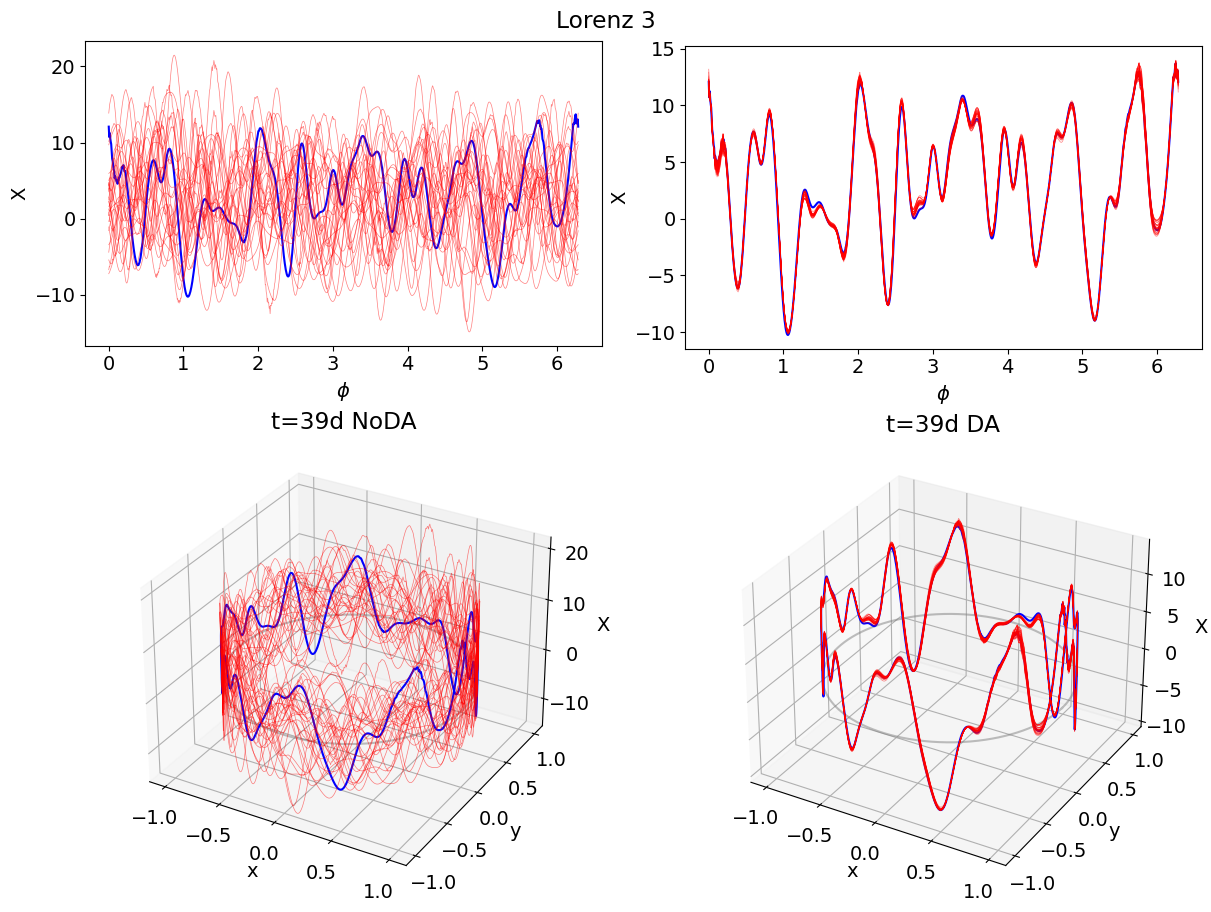

In [55]:
zb = np.hstack((z0,[z0[0]]))
zbe = np.vstack((z0e,z0e[0].reshape(1,-1)))
zba = np.vstack((z0a,z0a[0].reshape(1,-1)))
fig = plt.figure(figsize=[12,9],constrained_layout=True)
gs = gridspec.GridSpec(1,2,figure=fig)
gs0 = gs[0].subgridspec(5,1)
ax0 = fig.add_subplot(gs0[:2,:])
ax1 = fig.add_subplot(gs0[2:,:],projection='3d')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel('X')
ax1.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_zlabel('X')
gs1 = gs[1].subgridspec(5,1)
ax2 = fig.add_subplot(gs1[:2,:])
ax3 = fig.add_subplot(gs1[2:,:],projection='3d')
ax2.set_xlabel(r'$\phi$')
ax2.set_ylabel('X')
ax3.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
#ax3.set_xticklabels([])
#ax3.set_yticklabels([])
ax3.set_zlabel('X')
labels = []
lines = []
ax0.plot(phi,zb,c='b',lw=1.5)
ax1.plot(x,y,zb,c='b',lw=1.5)
ax2.plot(phi,zb,c='b',lw=1.5)
ax3.plot(x,y,zb,c='b',lw=1.5)
labels.append('truth')
lines.append(Line2D([0],[0],color='b',lw=1.5))
for i in range(zbe.shape[1]):
    #c = cmap(i)
    c = 'r'
    ax0.plot(phi,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x,y,zbe[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('ensemble forecast')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax1.set_title(f't={int(t/0.05/4)}d NoDA')
for i in range(zba.shape[1]):
    #c = cmap(i)
    c = 'r'
    ax2.plot(phi,zba[:,i],c=c,lw=0.5,alpha=0.5)
    ax3.plot(x,y,zba[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('ensemble analysis')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax3.set_title(f't={int(t/0.05/4)}d DA')
fig.suptitle(f'Lorenz {model}')
fig.savefig(workdir/'chaos_da.png',dpi=300)
plt.show()

it=0 icycle=-19


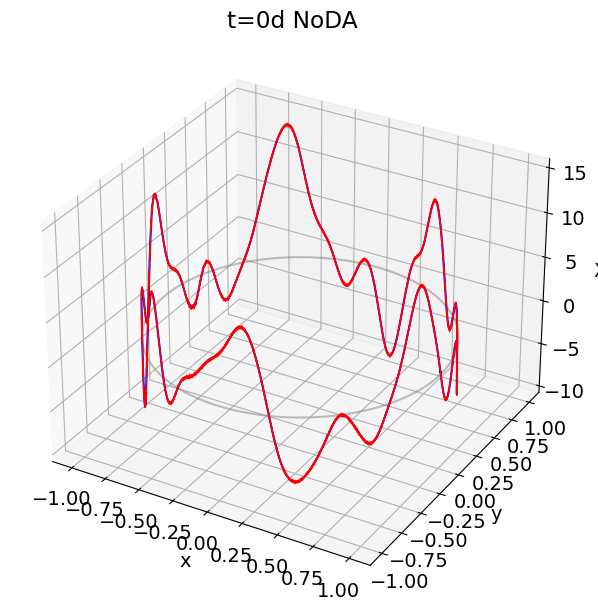

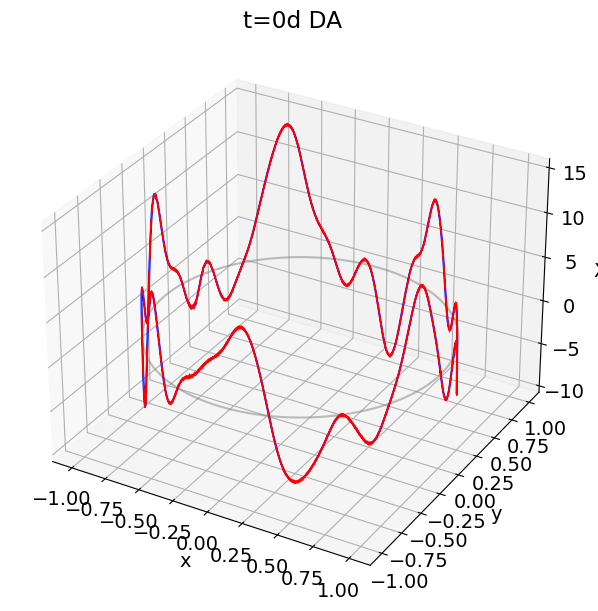

it=20 icycle=-14


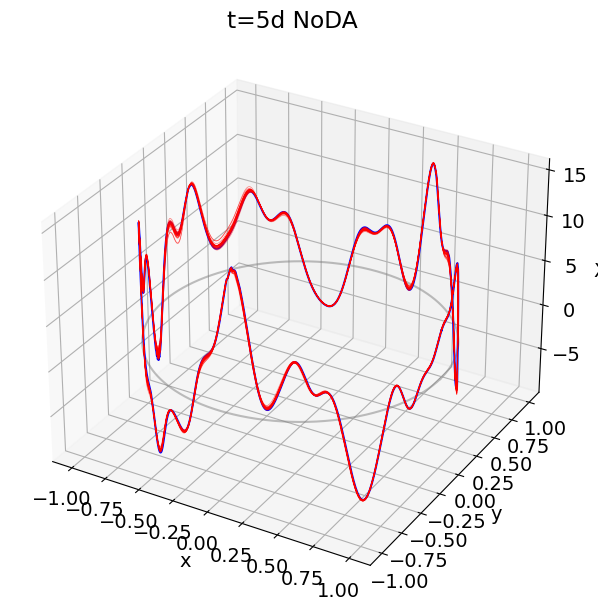

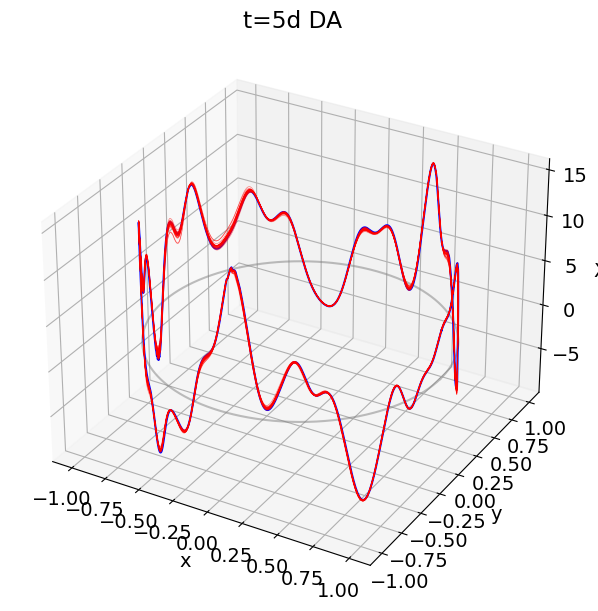

it=40 icycle=-9


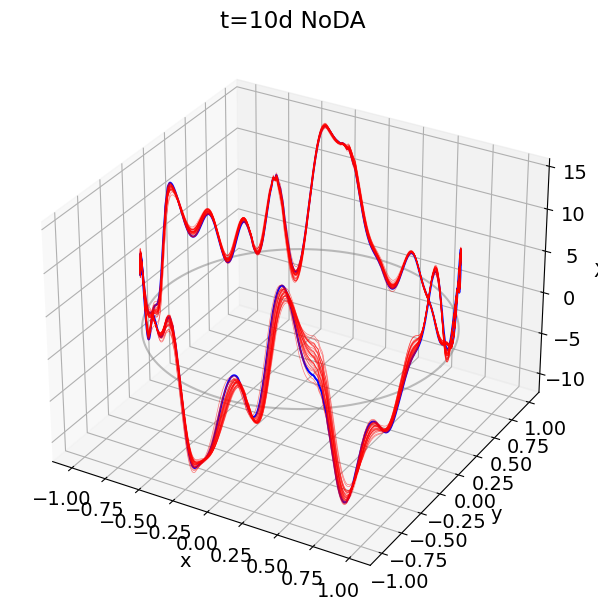

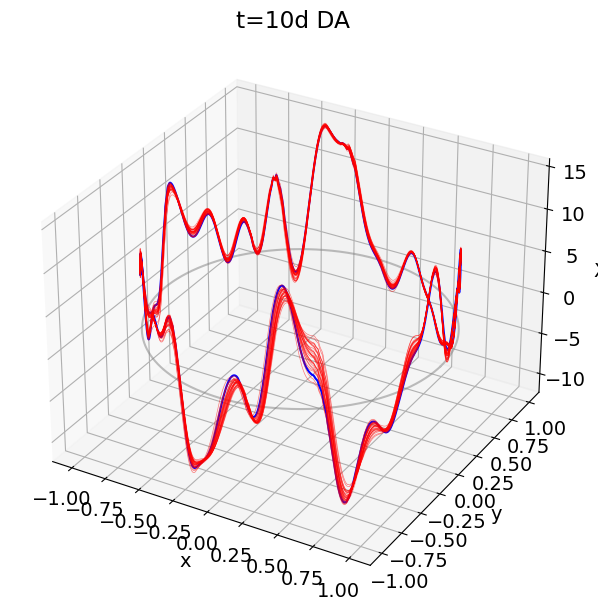

it=60 icycle=-4


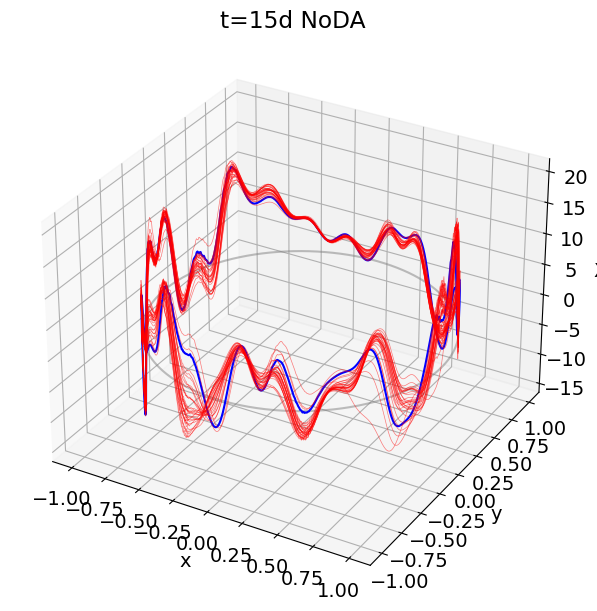

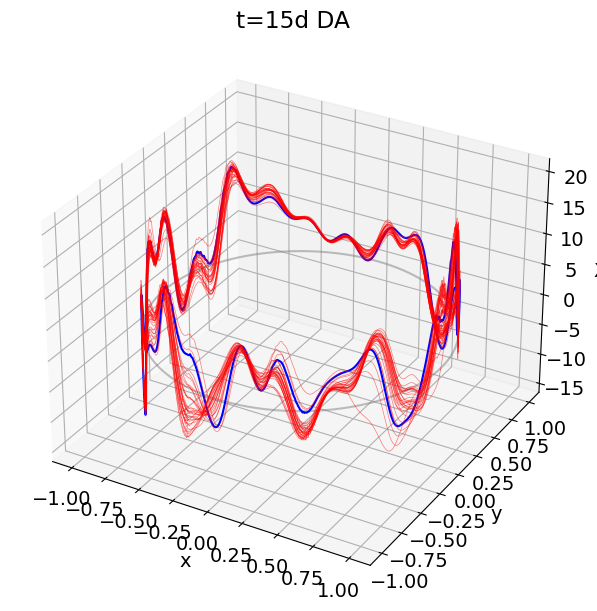

it=80 icycle=1


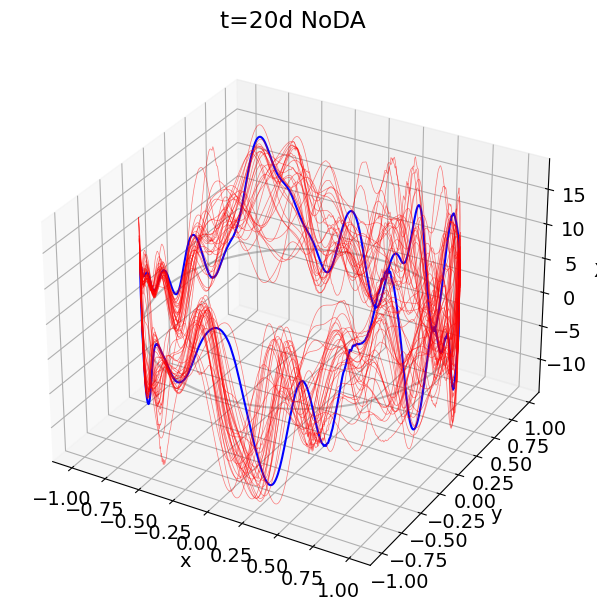

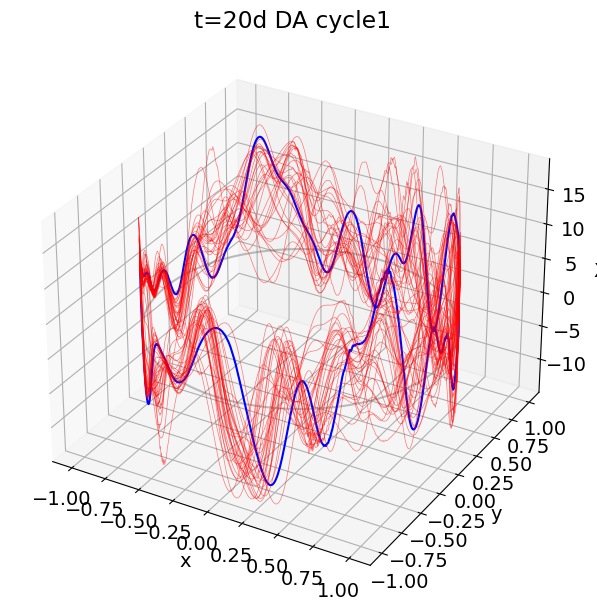

it=100 icycle=6


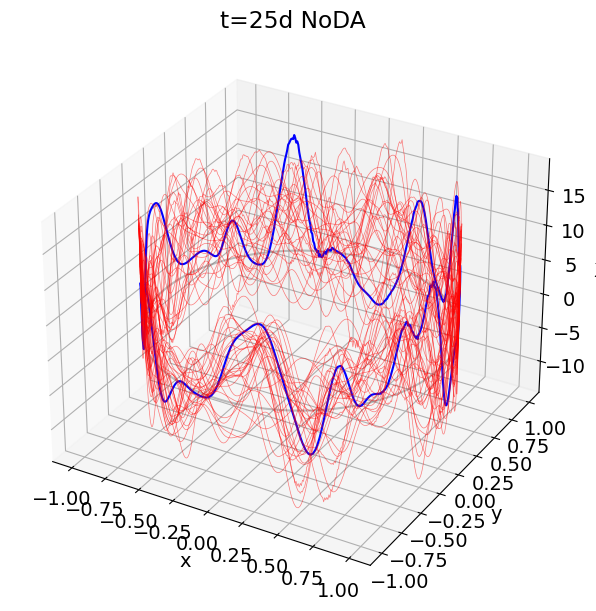

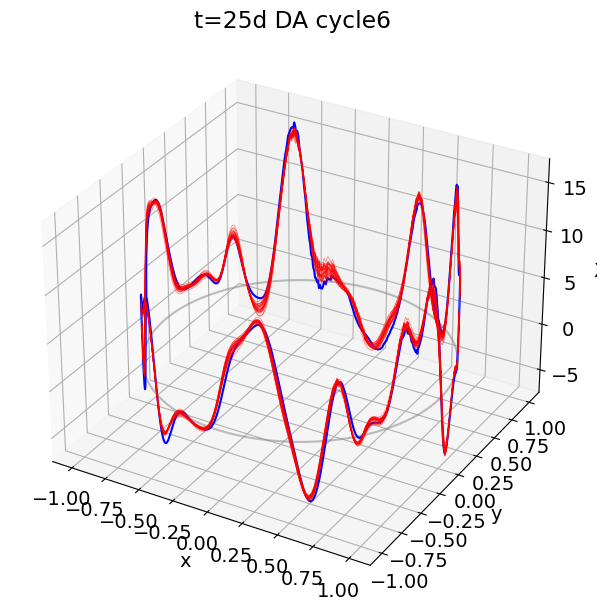

it=120 icycle=11


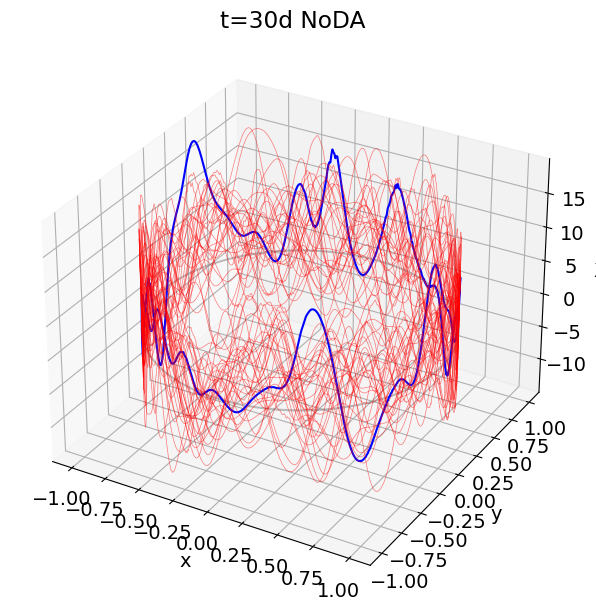

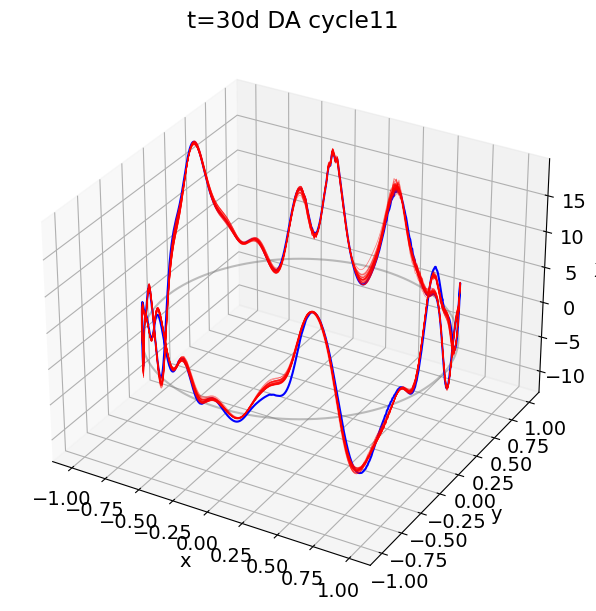

it=140 icycle=16


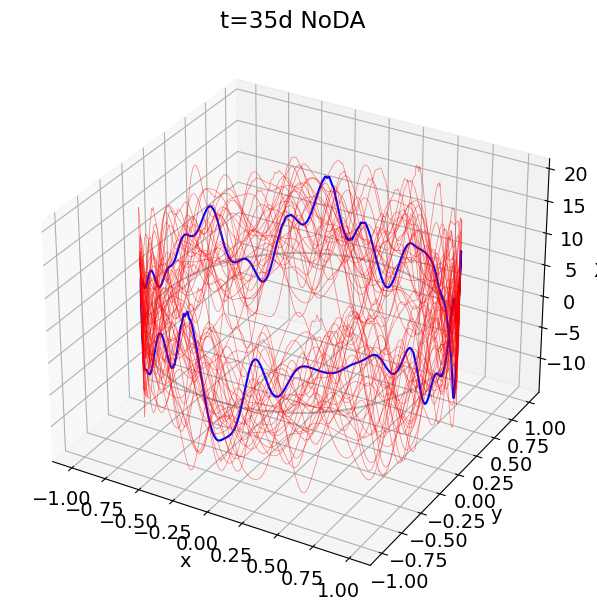

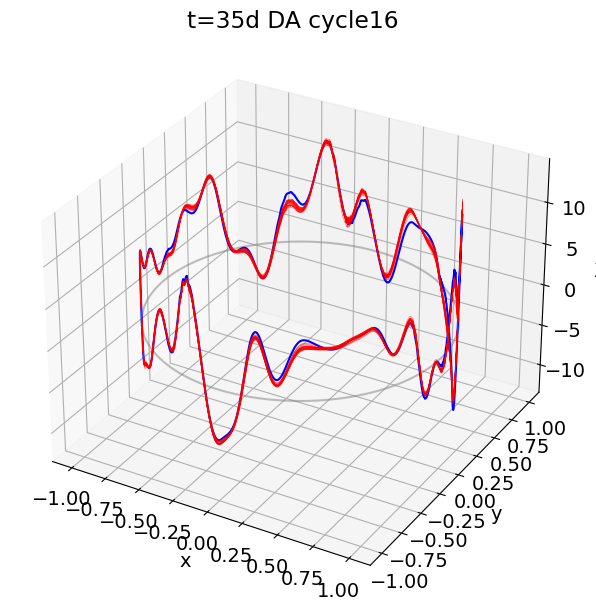

it=160 icycle=21


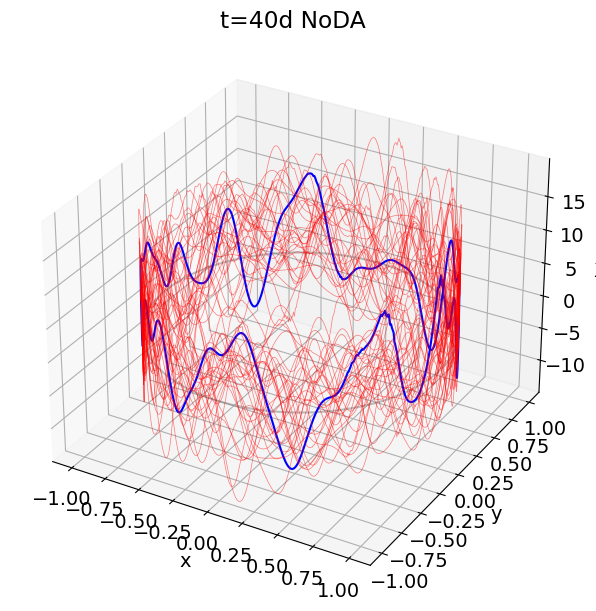

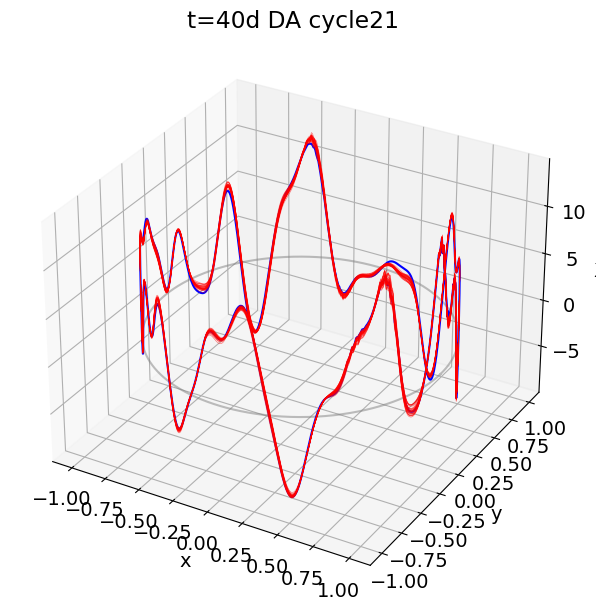

In [70]:
dindex = np.arange(0,45,5)
for day in dindex:
    it = day * nt24h // nt6h
    icycle = (it - nstanl//nt6h)//4 + 1
    print(f"it={it} icycle={icycle}")
    zt1 = zt[it]
    ze1 = ze[it]
    za1 = za[it]
    zb = np.hstack((zt1,[zt1[0]]))
    zbe = np.vstack((ze1,ze1[0].reshape(1,-1)))
    zba = np.vstack((za1,za1[0].reshape(1,-1)))
    fig = plt.figure(figsize=[6,6],constrained_layout=True)
    ax = fig.add_subplot(111,projection='3d')
    ax.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.set_zlabel('X')
    labels = []
    lines = []
    ax.plot(x,y,zb,c='b',lw=1.5)
    labels.append('truth')
    lines.append(Line2D([0],[0],color='b',lw=1.5))
    for i in range(zbe.shape[1]):
        #c = cmap(i)
        c = 'r'
        ax.plot(x,y,zbe[:,i],c=c,lw=0.5,alpha=0.5)
        if i==0:
            labels.append('ensemble')
            lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
    ax.set_title(f't={day}d NoDA')
    fig.savefig(workdir/f'chaos_noda_d{day}.png',dpi=300)
    plt.show()
    plt.close()
    fig = plt.figure(figsize=[6,6],constrained_layout=True)
    ax = fig.add_subplot(111,projection='3d')
    ax.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.set_zlabel('X')
    labels = []
    lines = []
    ax.plot(x,y,zb,c='b',lw=1.5)
    labels.append('truth')
    lines.append(Line2D([0],[0],color='b',lw=1.5))
    for i in range(zba.shape[1]):
        #c = cmap(i)
        c = 'r'
        ax.plot(x,y,zba[:,i],c=c,lw=0.5,alpha=0.5)
        if i==0:
            labels.append('ensemble')
            lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
    if icycle > 0:
        ax.set_title(f't={day}d DA cycle{icycle}')
    else:
        ax.set_title(f't={day}d DA')
    fig.savefig(workdir/f'chaos_da_d{day}.png',dpi=300)
    plt.show()
    plt.close()

### animation

2024-02-07 18:54:27,948 matplotlib.animation INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


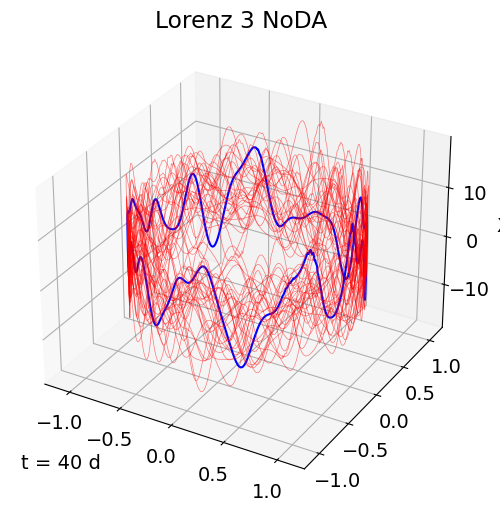

In [56]:
import matplotlib.animation as animation

zmin = np.min(np.array(zt))
zmax = np.max(np.array(zt))
fig= plt.figure(figsize=[6,6])
ax = fig.add_subplot(projection='3d',\
    autoscale_on=False,xlim=(-1.2,1.2),ylim=(-1.2,1.2),zlim=(zmin-0.1,zmax+0.1))
ax.set_zlabel('X')
ax.set_title(f'Lorenz {model} NoDA')
lines = []
truth, = ax.plot([],[],[],c='b',lw=1.5)
lines.append(truth)
for j in range(1,ne+1):
    ensfcst, = ax.plot([],[],[],c='r',lw=0.5,alpha=0.5)
    lines.append(ensfcst)
time_template = 't = %d d'
time_text = ax.text(0.05,0.9,20.0,'',\
    va='bottom',ha='left',transform=ax.transAxes)

def animate(i, zt, ze, lines):
    t=int(i*nt6h*h/0.05/4)
    zt0 = zt[i]
    ze0 = ze[i]
    zb = np.hstack((zt0,[zt0[0]]))
    zbe = np.vstack((ze0,ze0[0,:].reshape(1,-1)))
    for j, line in enumerate(lines):
        line.set_data(x,y)
        if j==0:
            line.set_3d_properties(zb)
        else:
            line.set_3d_properties(zbe[:,j-1])
    time_text.set_text(time_template % t)
    outlist = lines + [time_text]
    return outlist

ani = animation.FuncAnimation(fig, animate, len(ze),\
    fargs=(zt,ze,lines), interval=50)
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save(workdir/'chaos_noda.gif', writer=writer)

plt.show()

2024-02-07 19:35:44,822 matplotlib.animation INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


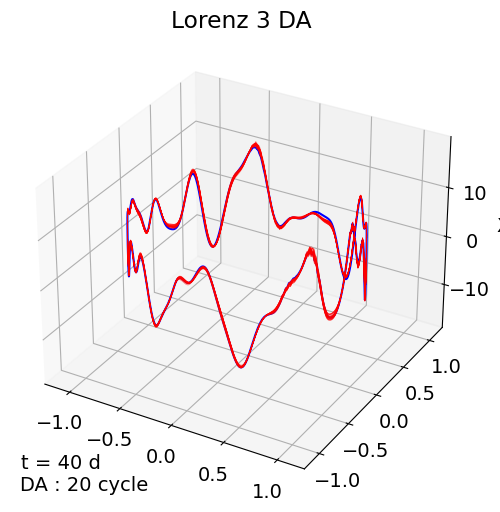

In [69]:
zmin = np.min(np.array(zt))
zmax = np.max(np.array(zt))
fig= plt.figure(figsize=[6,6])
ax = fig.add_subplot(projection='3d',\
    autoscale_on=False,xlim=(-1.2,1.2),ylim=(-1.2,1.2),zlim=(zmin-0.1,zmax+0.1))
ax.set_zlabel('X')
ax.set_title(f'Lorenz {model} DA')
lines = []
truth, = ax.plot([],[],[],c='b',lw=1.5)
lines.append(truth)
for j in range(1,ne+1):
    ensfcst, = ax.plot([],[],[],c='r',lw=0.5,alpha=0.5)
    lines.append(ensfcst)
time_template = 't = %d d'
time_text = ax.text(0.05,0.9,20.0,'',\
    va='bottom',ha='left',transform=ax.transAxes)
cycle_template = 'DA : %d cycle'
cycle_text = ax.text(0.05,0.9,-5.0,'',\
    va='bottom',ha='left',transform=ax.transAxes)

def animate(i, zt, za, lines):
    t=int(i*nt6h*h/0.05/4)
    zt0 = zt[i]
    za0 = za[i]
    zb = np.hstack((zt0,[zt0[0]]))
    zba = np.vstack((za0,za0[0,:].reshape(1,-1)))
    for j, line in enumerate(lines):
        line.set_data(x,y)
        if j==0:
            line.set_3d_properties(zb)
        else:
            line.set_3d_properties(zba[:,j-1])
    time_text.set_text(time_template % t)
    outlist = lines + [time_text]
    if i*nt6h >= nstanl and i%4==0:
        icycle = (i - nstanl//nt6h)//4 + 1
        cycle_text.set_text(cycle_template % icycle)
        outlist = outlist + [cycle_text]
    return outlist

ani = animation.FuncAnimation(fig, animate, len(za),\
    fargs=(zt,za,lines), interval=50)
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save(workdir/'chaos_da.gif', writer=writer)

plt.show()